In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
# load data from a csv file
df = pd.read_csv('/content/sample_data/train.csv')
df = df.drop('Id', axis=1)
# fill missing values with mean of respective feature 
df = df.fillna(df.mean())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [ ]:
# !pip install shap
import shap
import matplotlib.pylab as pl
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import lightgbm as lgb

<h1>Predict house price using lightgbm model</h1>

In [ ]:
# we consider numerical features only
df_num = df.select_dtypes(include = ['float64', 'int64'])
X = df_num.iloc[:, :-1]
y = df_num.iloc[:, -1]
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# train model using lightgbm
model = lgb.LGBMRegressor()
# model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared = False)


<h1>Explain the model's predictions on the entire dataset<h1>
<h2>What is SHAP?</h2>
SHAP (SHapley Additive exPlanations) is a method used in machine learning to explain the predictions made by a model. It provides a way to attribute a prediction to different input variables or features, by deconstructing the prediction into contributions from each input variable. SHAP values are based on cooperative game theory and provide a fair way to allocate the prediction's value to the individual input variables, considering their interactions and dependencies. SHAP values can help interpret the decision-making process of machine learning models and understand the relative importance of different features in making predictions.

<h2>Compute SHAP Values<h2>


In [ ]:
shap_values = shap.TreeExplainer(model).shap_values(X)

<h2>SHAP Summary Plot</h2>
It tells which features are most important, and also their range of effects over the dataset. The color allows us match how changes in the value of a feature effect the change in house price prediction.
<br>For instance, we see that lower values of OverallQual (Overall material and finish quality) have negative SHAP values and higher values of OverallQual have positive SHAP values. This indicates that houses that have higer Overall material and finish quality have higher predicted prices.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


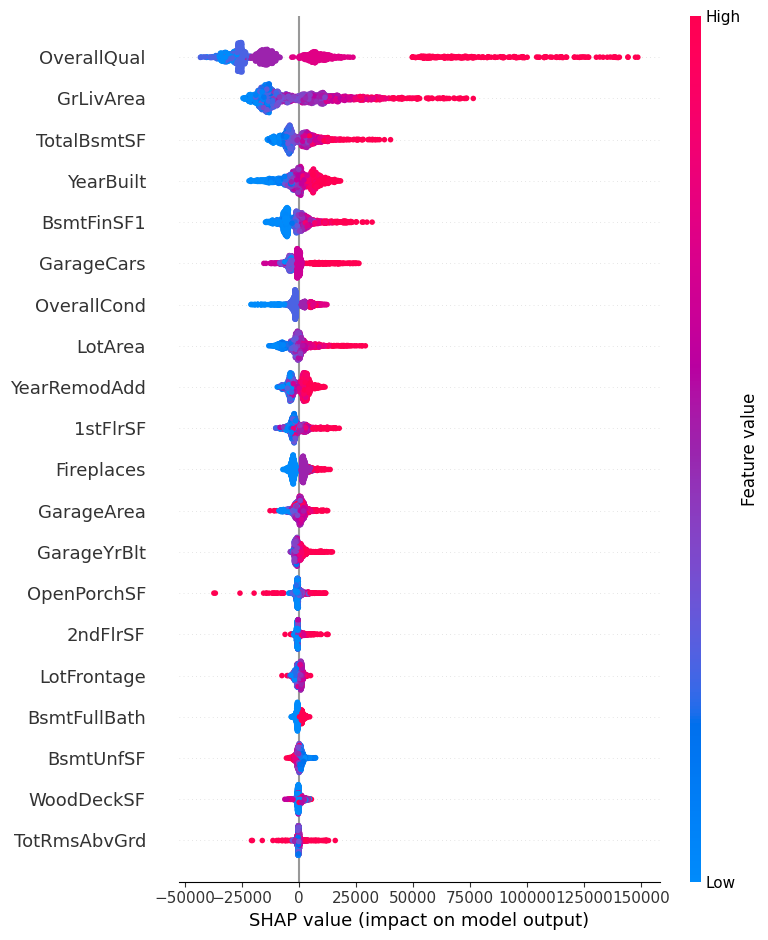

In [ ]:
shap.summary_plot(shap_values, X)

<h2>SHAP Dependence Plots</h2>
While SHAP summary plot provides a general overview of each feature, a SHAP dependence plot shows how the model's output changes with variations in the value of a specific feature. <br>
Below we give the SHAP dependence plot for each of top 3 features, and reveals that the relationship between SHAP values and variable values are quite different for each of them. For example, OverallQual = 7 can have the SHAP value ranging from \$0 to \$25000. This graph should be demonstrated in 1 color.
<br>The SHAP value of a feature for a particular instance is not solely determined by the value of that feature, but it is also influenced by the values of the other features in that instance. For example, at GrLivArea (Above grade (ground) living area square feet) = 1700, the SHAP values ranging from -\$15000 to \$15000. For this region, the instances with highest TotalBsmtSF (Total square feet of basement area) values have the lowest SHAP values, whereas instances with lower TotalBsmtSF have higher SHAP values.

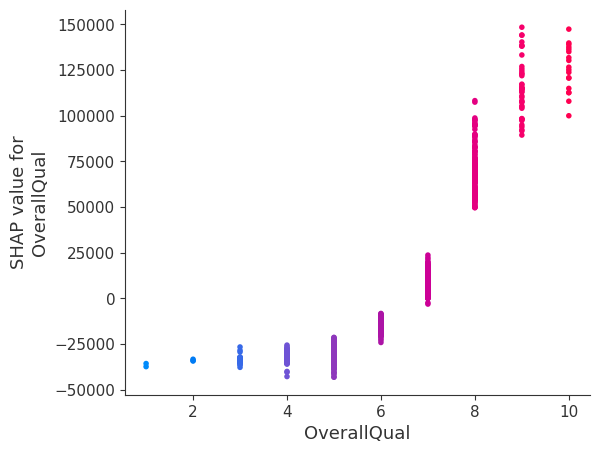

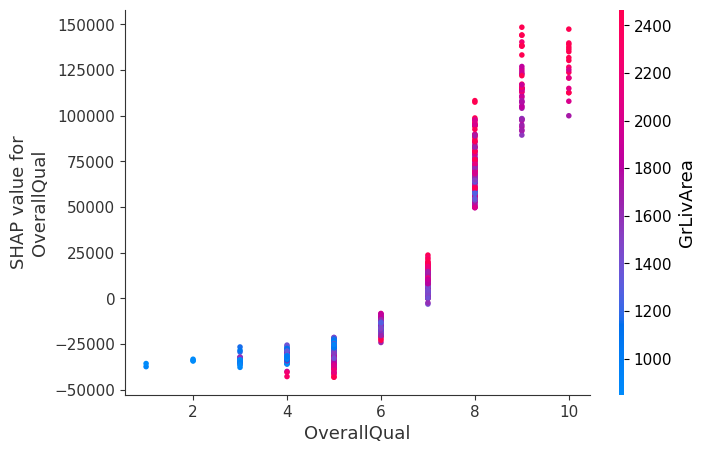

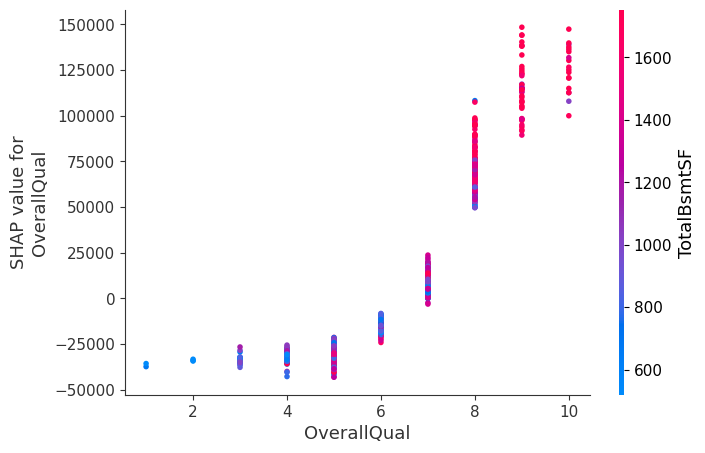

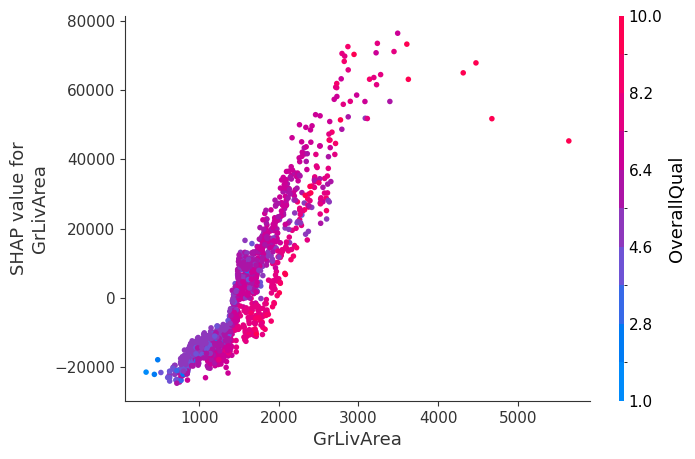

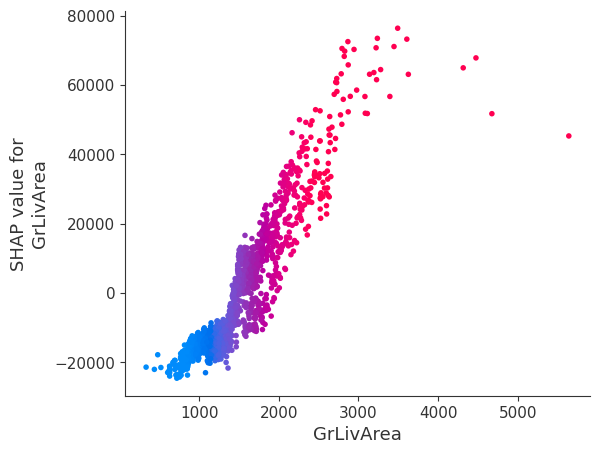

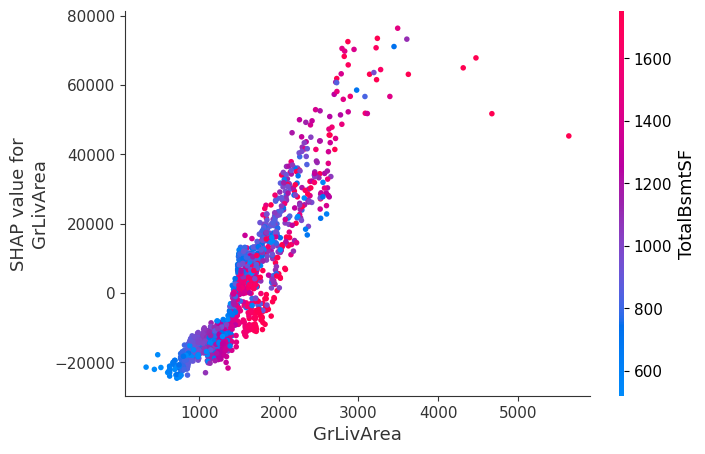

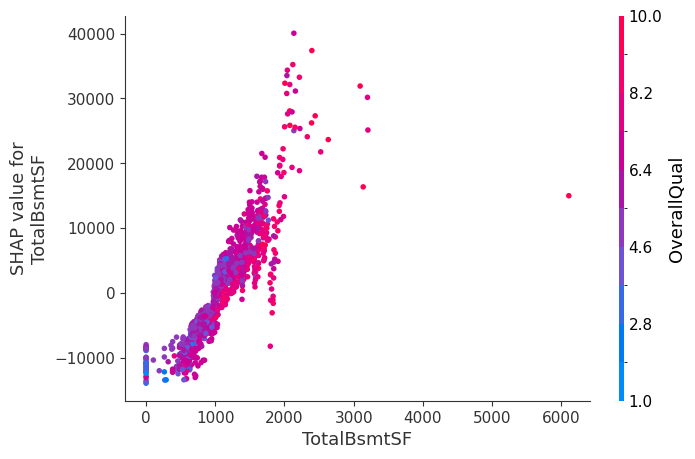

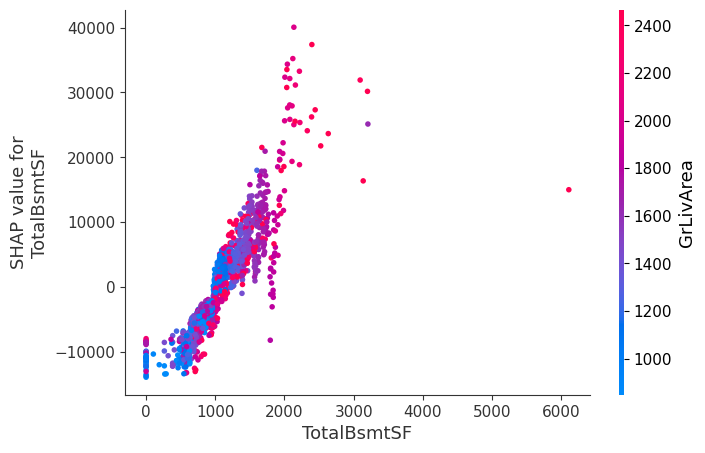

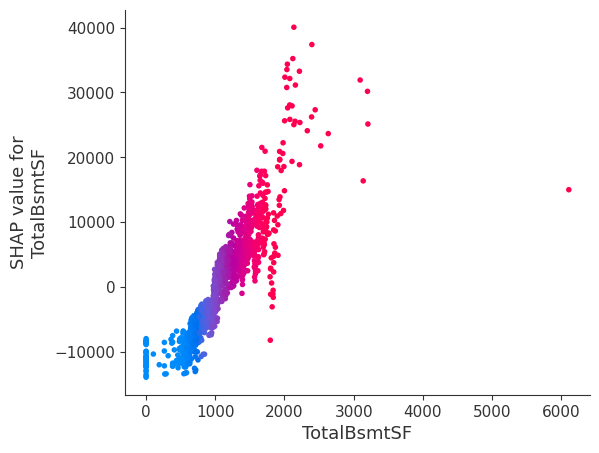

In [ ]:
top_features = ['OverallQual', 'GrLivArea','TotalBsmtSF']
for i in range(len(top_features)):
    for j in range(len(top_features)):
        shap.dependence_plot(top_features[i], shap_values, X, interaction_index=top_features[j])

<h2>SHAP Interaction Value Summary Plot</h2>
A SHAP Interaction Value Summary Plot is a graphical representation that shows a matrix of summary plots, where the main effects of features are displayed on the diagonal, and the interaction effects between pairs of features are shown off the diagonal.


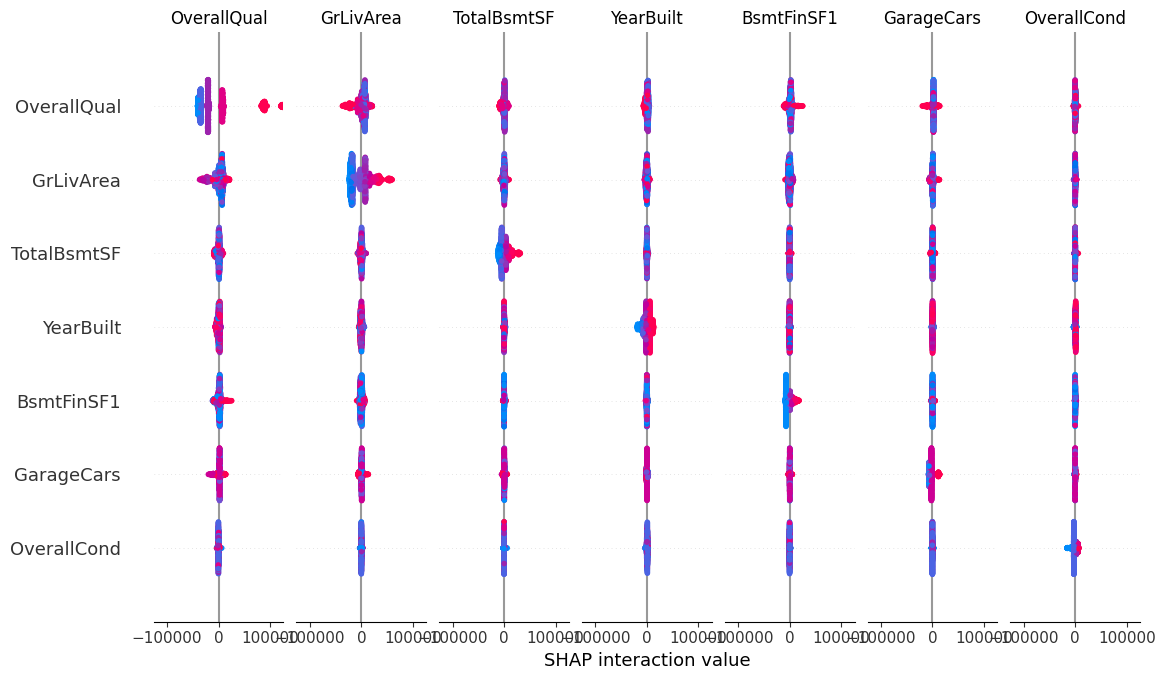

In [ ]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X.iloc[:,:])
shap.summary_plot(shap_interaction_values, X.iloc[:,:])

<h2>SHAP Interaction Value Dependence Plots</h2>
<h4>Running a dependence plot on the SHAP interaction values allows us to separately observe the main effects and the interaction effects. Below we plot the main effects of OveralQual and interaction effects for OverQual, in this example is YearBuilt. It is informative to compare the main effects plot of OveralQual with the earlier SHAP value plot for OveralQual.</h4>

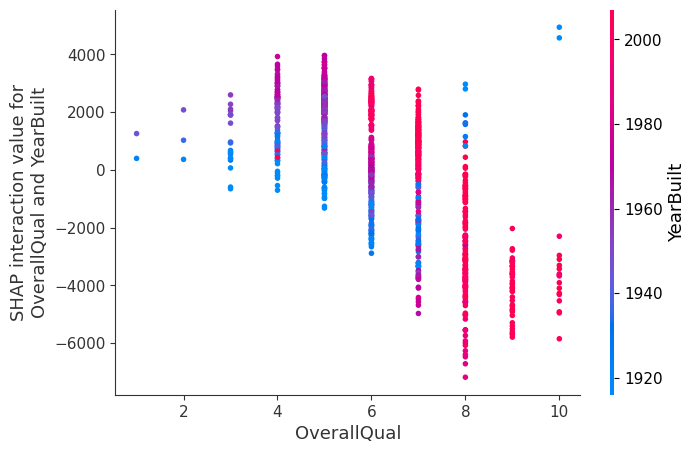

In [ ]:
shap.dependence_plot(
    ("OverallQual", "YearBuilt"),
    shap_interaction_values, X.iloc[:,:],
    display_features=X.iloc[:,:]
)

Create a heatmap plot to visualize the interaction values of a set of features




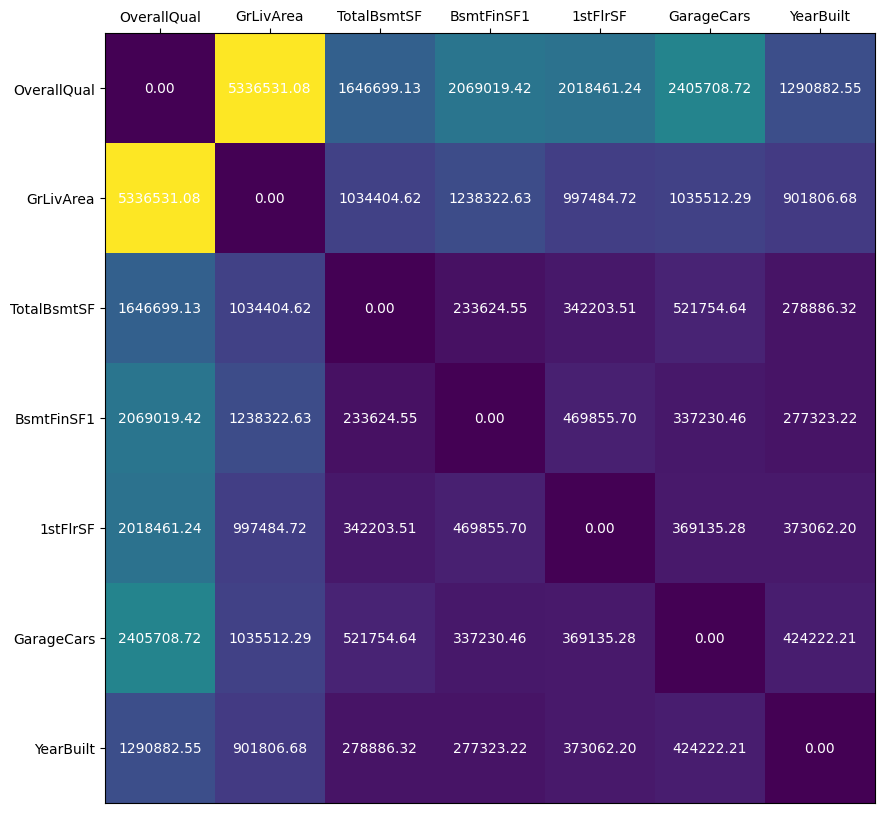

In [ ]:
temp = np.abs(shap_interaction_values).sum(0)
# sets the diagonal values of tmp to 0 to remove the self-interaction values
for i in range(temp.shape[0]):
    temp[i,i] = 0
# sorts the sum of interaction values in descending order and selects the top 7 indices
indices = np.argsort(-temp.sum(0))[:7]
temp1 = temp[indices,:][:,indices]
pl.figure(figsize=(10,10))
pl.imshow(temp1)
for i in range(temp1.shape[0]):
    for j in range(temp1.shape[1]):
        pl.text(j, i, f"{temp1[i,j]:.2f}", ha='center', va='center', color='w')
pl.yticks(range(temp1.shape[0]), X.columns[indices])
pl.xticks(range(temp1.shape[0]), X.columns[indices])
pl.gca().xaxis.tick_top()
pl.show()